In [1]:
import os
import time
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, CuDNNLSTM
from keras.optimizers import Adam
from keras import backend as K
import time as t_lib
import tensorflow as tf
from threading import Thread
from IPython.display import clear_output
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
DATAFRAME_NAME = 'EURUSD_m15_Ask_ready.csv'
NUMBER_OF_SAMPLES = 50

EPISODES = 5000
TICQTY_MAX = 55000
HOLD_REWARD = 0
OPEN_TRADE_REWARD = 0
CLOSING_TRADE_WITH_OPENING = 100  #20
DIVIDE_PRICE_UNDER_LOCAL_MINIMA = 1  #10
REWARD_FOR_PIPS = 10000
TIMES_FACTOR = 4 #10
NEGATIVE_REWARD_DIVIDE = 4 # kolikrat bude mensi times factor pri zaporne odmene

ACTION_DECODE = {
    0: 0,
    1: 0.5,
    2: 1,
}


In [3]:
class Dataframe:

    def __init__(self):
        self._dataframe = self._load()[0:2000]
        self.__scaler = MinMaxScaler()

    @property
    def lenght(self):
        return len(self._dataframe.index) - NUMBER_OF_SAMPLES

    def get(self, sample_number):
        if sample_number > self.lenght or sample_number < 0:
            raise ValueError("Sample number out of range (0 - {self.lenght})")

        start_index = sample_number
        end_index = start_index + NUMBER_OF_SAMPLES

        df_sample = self._dataframe[start_index: end_index]

        last_open = df_sample.at[df_sample.index[-1], 'open']
        last_close = df_sample.at[df_sample.index[-1], 'close']

        df_sample = df_sample[['open', 'close', 'high', 'low', 'tickqty', 'hours', 'minutes']].values
        df_sample = self._scale(df_sample, start=0, end=4)
        return np.expand_dims(df_sample, axis=0), last_open, last_close

    @staticmethod
    def _load():
        """ Creating relative path and then loading the df_path """
        """
        df_path = os.path.join(os.path.dirname(os.path.abspath(__file__)) +
                               os.path.normpath(f'/dfs/{cfg.DATAFRAME_NAME}'))
        """
        df_path = './dfs/{}'.format(DATAFRAME_NAME)
        df = pd.read_csv(
            df_path,
            dtype={
                'datetime'
                'open': np.float32,
                'close': np.float32,
                'high': np.float32,
                'low': np.float32,
                'tickqty': np.float32,
            }
        )

        # df['hours']= pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f').dt.hour / 24
        df['hours'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.hour / 24
        df['minutes'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.minute / 64
        df['tickqty'] = df['tickqty'] / TICQTY_MAX
        return df

    def _scale(self, array: np.ndarray, start: int, end: int):
        columns = array.T[start: end].T

        self.__scaler.fit(columns)
        scaled_cols = self.__scaler.transform(columns).T
        array.T[start:end] = scaled_cols
        return array

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.sample_memory = deque()
        
        self.gamma = 0.99  # discount rate
        
        self.epsilon = 1 # exploration rate
        self.epsilon_min = 0.0
        self.epsilon_decay = 0.9996
        
        self.learning_rate = 0.001
        self.learning_rate_decay = 0.99999
        self.learning_rate_min = 0.0001
        
        self.batch_size_samples = 500
        self.batch_size = batch_size
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning

    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))

        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.sample_memory.append((state, action, reward, next_state, done))
    
    def train_from_iterations(self):
        while True:
            if len(self.sample_memory) != 0:
                state, action, reward, next_state, done = self.sample_memory.popleft()
                self.train(state, action, reward, next_state, done)

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(state, steps=1, verbose=0)
        if done and reward > 80 * TIMES_FACTOR:
            target[0][action] = reward
        else:
            # a = self.model.predict(next_state)[0]
            t = self.target_model.predict(next_state)[0]
            target[0][action] = reward + self.gamma * np.amax(t)
            # target[0][action] = reward + self.gamma * t[np.argmax(a)]
        self.model.fit(state, target, epochs=1, verbose=0)
        # print('done')

    def act(self, state):
        if not isinstance(state, np.ndarray):
            return 0

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size), True
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0]), False  # returns action

    def predict(self, state):
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0])  # returns action

    def replay(self):
        while True:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                if not isinstance(state, np.ndarray):
                    continue
                
                self.train(state, action, reward, next_state, done)
                """
                target = self.model.predict(state, steps=1, verbose=0)
                if done and reward > 80 * TIMES_FACTOR:
                    target[0][action] = reward
                else:
                    # a = self.model.predict(next_state)[0]
                    t = self.target_model.predict(next_state)[0]
                    target[0][action] = reward + self.gamma * np.amax(t)
                    # target[0][action] = reward + self.gamma * t[np.argmax(a)]
                self.model.fit(state, target, epochs=1, verbose=0)
                """
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = self.epsilon_min
            
            if self.learning_rate > self.learning_rate_min:
                self.learning_rate *= self.learning_rate_decay
            else:
                self.learning_rate = self.learning_rate_min
            # print('done')
    
    def set_learning_rate(self):
        K.set_value(self.model.optimizer.lr, self.learning_rate)  # set new lr
        K.set_value(self.target_model.optimizer.lr, self.learning_rate)  # set new lr

    def load(self, name):
        self.model.load_weights(name)
        self.model._make_predict_function()
        self.model._make_test_function()
        self.model._make_train_function()

        self.target_model.load_weights(name)
        self.target_model._make_predict_function()
        self.target_model._make_test_function()
        self.target_model._make_train_function()

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
class Trevor:
    POSITIVE_TIMES_REWARD = 0 #0.00001
    NEGATIVE_TIMES_REWARD = 0 #0.00001

    def __init__(self, df):
        self.df = df

        self.cursor = 0
        self.enter_price = 0
        self.local_max_price = 0

        self.last_action = 0

        self.closed_counter = 0
        self.total_reward = 0
        self.trade_counter = 0

        self.closed_counter_list = []

    def reset(self):
        self.cursor = 0
        self.enter_price = 0
        self.last_action = 0
        self.closed_counter = 0
        self.trade_counter = 0
        self.total_reward = 0
        # self.reset_closed_list()

        return self.step(0)[0]

    def step(self, action):
        sample, last_open, last_close = self.df.get(self.cursor)

        reward, closing_trade = self.__process_action(action=action, last_close=last_close)
        sample = self.__append_last_action(sample=sample, action=action, last_close=last_close)

        self.__increment_cursor()

        return sample, reward, closing_trade, ''

    def get_total_reward(self):
        return self.total_reward

    def reset_closed_list(self):
        self.closed_counter_list = []

    def plot(self, title):
        x = list(range(1, len(self.closed_counter_list) + 1))
        pyplot.plot(x, self.closed_counter_list)
        pyplot.title(str(title))
        pyplot.show()

    def __process_action(self, action, last_close):
        if action < 0 or action > 2:
            raise ValueError('Action have to be inrage (0 - 2) got {action}')

        closing_trade = False

        # """ CLOSING POSITION """
        if (self.last_action == 2 and action == 0) or (self.last_action == 1 and action == 0):
            reward = self.__close_trade(last_close=last_close)
            closing_trade = True

        # """ CLOSING POSITION AND GOING TO DIFFERENT POSITION """
        elif (self.last_action == 2 and action == 1) or (self.last_action == 1 and action == 2):
            reward = self.__close_trade(last_close=last_close) - CLOSING_TRADE_WITH_OPENING
            self.enter_price = last_close
            self.local_max_price = last_close
            closing_trade = True

        # """ HOLDING OPENED POSITION  """
        elif (self.last_action == 2 and action == 2) or (self.last_action == 1 and action == 1):
            if self.last_action == 2:
                if self.local_max_price < last_close:
                    reward = (last_close - self.enter_price) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (last_close - self.local_max_price) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close > self.enter_price \
                        else reward

            else:
                if self.local_max_price > last_close:
                    reward = (self.enter_price - last_close) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (self.local_max_price - last_close) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close < self.enter_price \
                        else reward

        # """ OPENING POSITION  """
        elif (self.last_action == 0 and action == 1) or (self.last_action == 0 and action == 2):
            self.enter_price = last_close
            self.local_max_price = last_close
            reward = OPEN_TRADE_REWARD

        # """ HOLD """
        elif self.last_action == 0 and action == 0:
            reward = HOLD_REWARD

        else:
            raise ValueError('Last action = {self.last_action} and actual_action = {action}')

        self.last_action = action
        self.total_reward += reward
        return reward, closing_trade

    def __increment_cursor(self):
        """ Incrementing the cursor, if the cursor is bigger than lenght of the dataframe, then reset it"""

        self.cursor += 1
        if self.cursor > self.df.lenght:
            self.cursor = 0

    def __close_trade(self, last_close):
        if self.last_action == 2:
            reward = (last_close - self.enter_price) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
            
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        else:
            reward = (self.enter_price - last_close) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
                
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        self.closed_counter_list.append(self.closed_counter)
        self.trade_counter += 1
        return reward

    def __append_last_action(self, sample: np.ndarray, action: int, last_close: float):
        how_many = sample.shape[1]
        decoded_action = ACTION_DECODE[action]

        action_arr = (np.expand_dims(np.asarray([decoded_action for i in range(0, how_many)]), axis=1))

        if action == 2 or action == 1:
            dif = (last_close - self.enter_price)
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        else:
            dif = 0
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        sample = np.append(sample[0], action_arr, axis=1)
        sample = np.append(sample, pip_difference, axis=1)

        return np.expand_dims(sample, axis=0)

C:\Users\Lukas\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


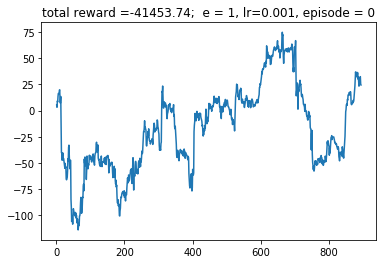

Waiting to train the whole dataset
action0:  630 
action1:  647 
action2:  673
DONE, lets roll!!
163.636


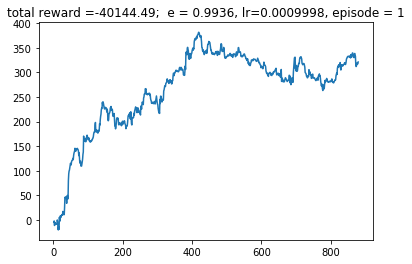

Waiting to train the whole dataset
action0:  644 
action1:  631 
action2:  675
DONE, lets roll!!
133.988


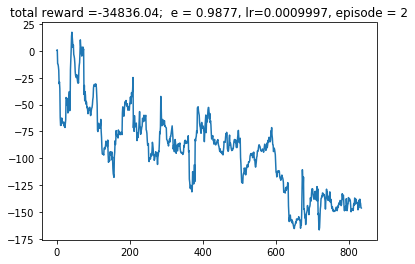

Waiting to train the whole dataset
action0:  681 
action1:  627 
action2:  642
DONE, lets roll!!
128.747


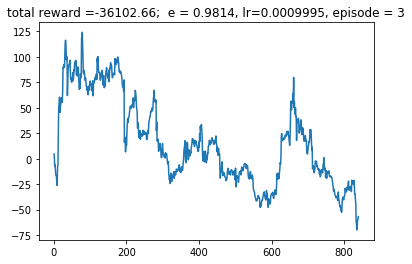

Waiting to train the whole dataset
action0:  687 
action1:  658 
action2:  605
DONE, lets roll!!
199.797


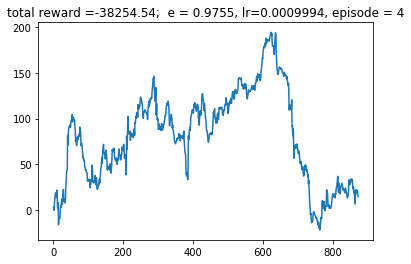

Waiting to train the whole dataset
action0:  648 
action1:  664 
action2:  638
DONE, lets roll!!
129.261


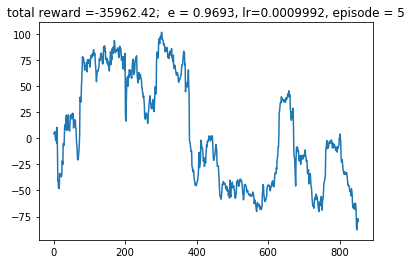

Waiting to train the whole dataset
action0:  691 
action1:  630 
action2:  629
DONE, lets roll!!
128.318


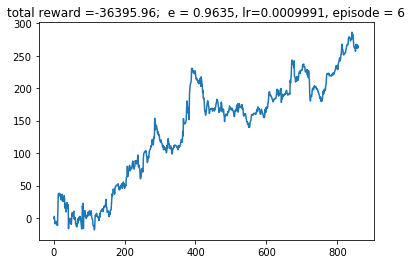

Waiting to train the whole dataset
action0:  682 
action1:  638 
action2:  630
DONE, lets roll!!
135.601


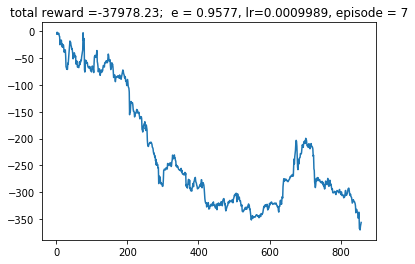

Waiting to train the whole dataset
action0:  694 
action1:  628 
action2:  628
DONE, lets roll!!
128.686


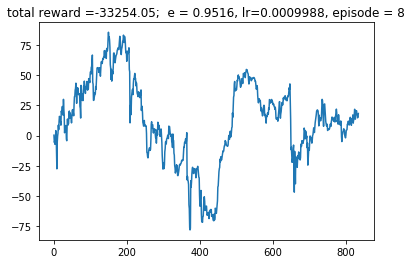

Waiting to train the whole dataset
action0:  749 
action1:  606 
action2:  595
DONE, lets roll!!
129.445


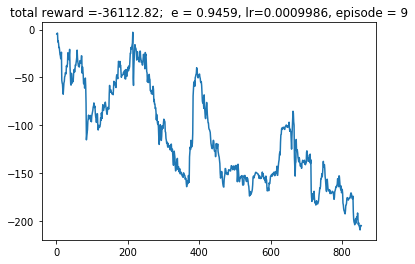

Waiting to train the whole dataset
action0:  723 
action1:  627 
action2:  600
DONE, lets roll!!
129.602


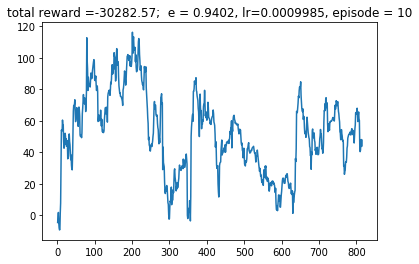

Waiting to train the whole dataset
action0:  739 
action1:  620 
action2:  591
DONE, lets roll!!
136.213


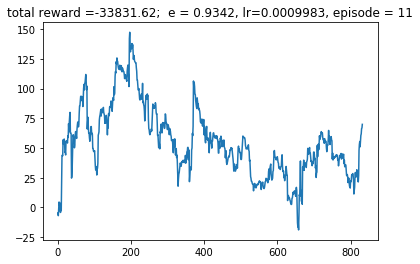

Waiting to train the whole dataset
action0:  751 
action1:  567 
action2:  632
DONE, lets roll!!
124.015


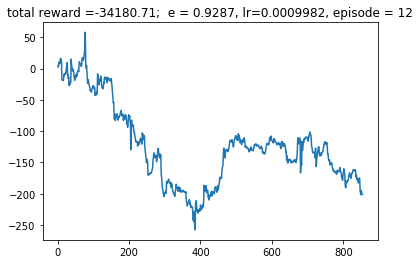

Waiting to train the whole dataset
action0:  755 
action1:  590 
action2:  605
DONE, lets roll!!
124.007


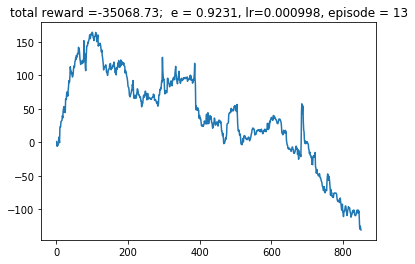

Waiting to train the whole dataset
action0:  741 
action1:  605 
action2:  604
DONE, lets roll!!
124.897


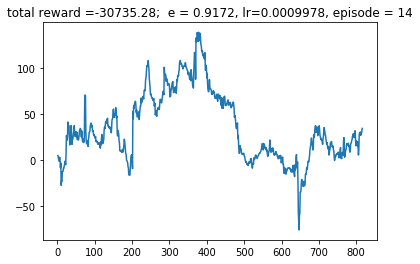

Waiting to train the whole dataset
action0:  773 
action1:  597 
action2:  580
DONE, lets roll!!
125.031


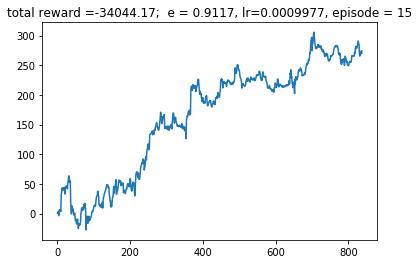

Waiting to train the whole dataset
action0:  755 
action1:  591 
action2:  604
DONE, lets roll!!
126.597


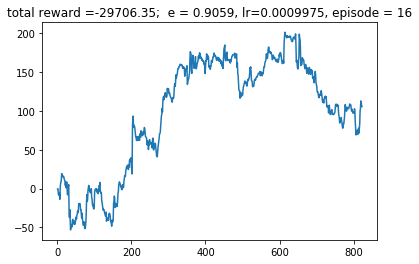

Waiting to train the whole dataset
action0:  760 
action1:  585 
action2:  605
DONE, lets roll!!
124.521


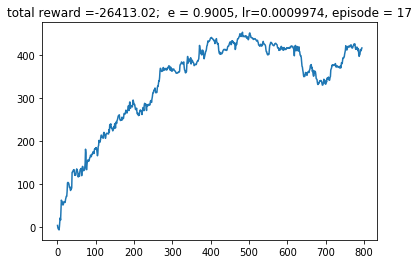

Waiting to train the whole dataset
action0:  794 
action1:  585 
action2:  571
DONE, lets roll!!
126.061


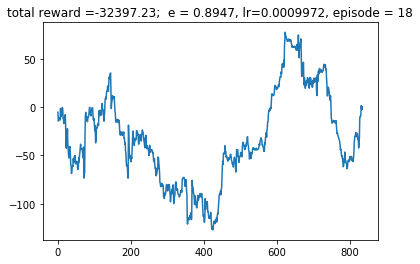

Waiting to train the whole dataset
action0:  765 
action1:  591 
action2:  594
DONE, lets roll!!
125.01


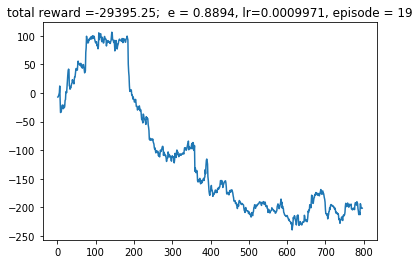

Waiting to train the whole dataset
action0:  802 
action1:  563 
action2:  585
DONE, lets roll!!
124.76


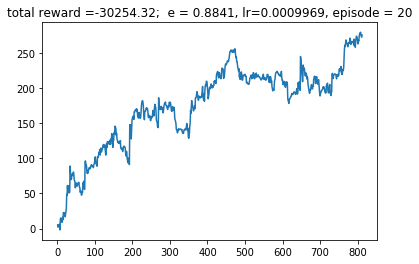

Waiting to train the whole dataset
action0:  776 
action1:  570 
action2:  604
DONE, lets roll!!
124.688


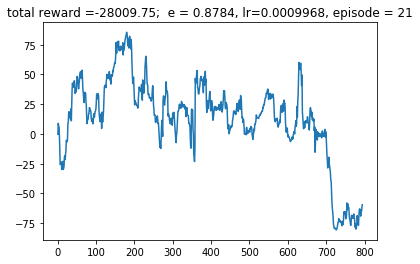

Waiting to train the whole dataset
action0:  825 
action1:  566 
action2:  559
DONE, lets roll!!
125.193


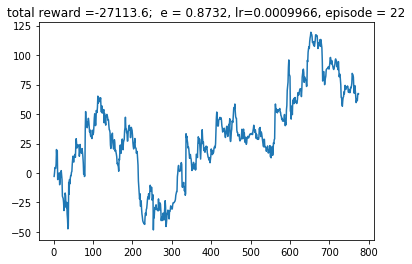

Waiting to train the whole dataset
action0:  852 
action1:  521 
action2:  577
DONE, lets roll!!
125.337


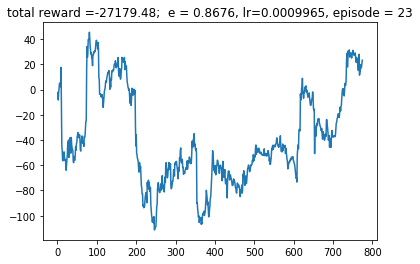

Waiting to train the whole dataset
action0:  870 
action1:  570 
action2:  510
DONE, lets roll!!
125.646


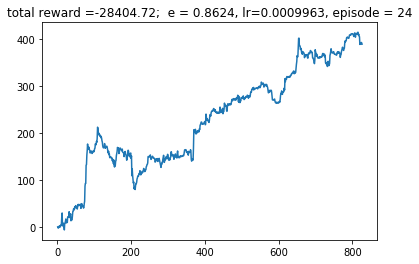

Waiting to train the whole dataset
action0:  835 
action1:  544 
action2:  571
DONE, lets roll!!
125.333


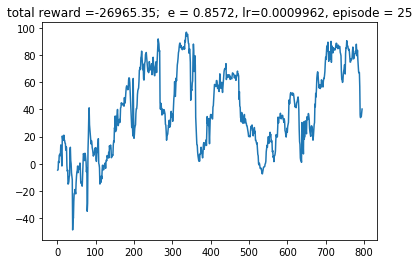

Waiting to train the whole dataset
action0:  822 
action1:  551 
action2:  577
DONE, lets roll!!
125.81


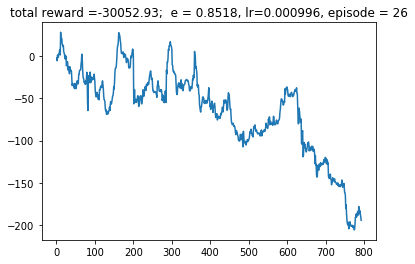

Waiting to train the whole dataset
action0:  834 
action1:  536 
action2:  580
DONE, lets roll!!
125.766


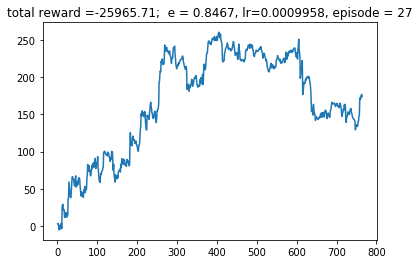

Waiting to train the whole dataset
action0:  858 
action1:  542 
action2:  550
DONE, lets roll!!
125.498


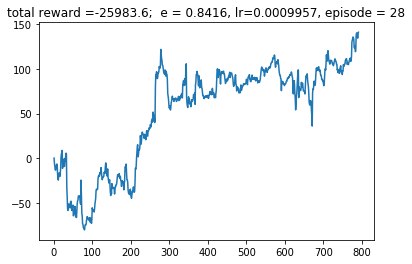

Waiting to train the whole dataset
action0:  884 
action1:  528 
action2:  538
DONE, lets roll!!
125.772


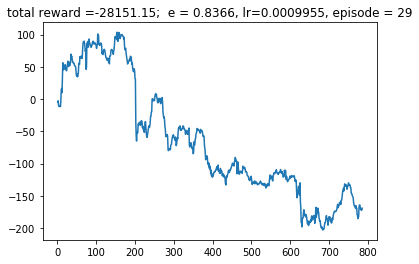

Waiting to train the whole dataset
action0:  832 
action1:  555 
action2:  563
DONE, lets roll!!
125.815


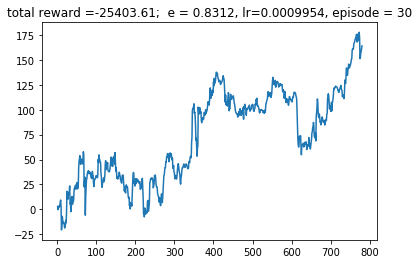

Waiting to train the whole dataset
action0:  873 
action1:  550 
action2:  527
DONE, lets roll!!
125.787


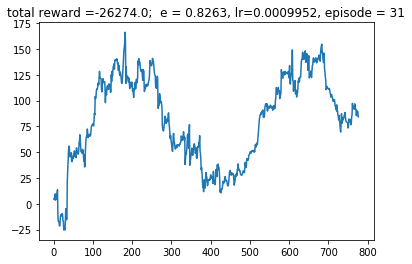

Waiting to train the whole dataset
action0:  828 
action1:  574 
action2:  548
DONE, lets roll!!
127.017


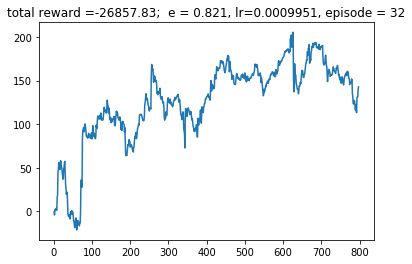

Waiting to train the whole dataset
action0:  875 
action1:  510 
action2:  565
DONE, lets roll!!
125.521


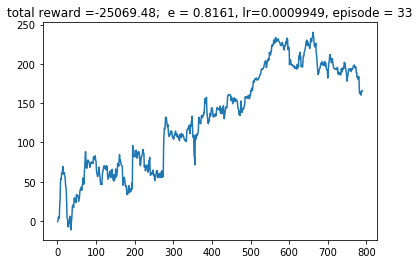

Waiting to train the whole dataset
action0:  868 
action1:  545 
action2:  537
DONE, lets roll!!
125.792


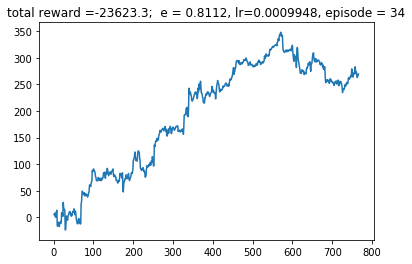

Waiting to train the whole dataset
action0:  851 
action1:  553 
action2:  546
DONE, lets roll!!
126.256


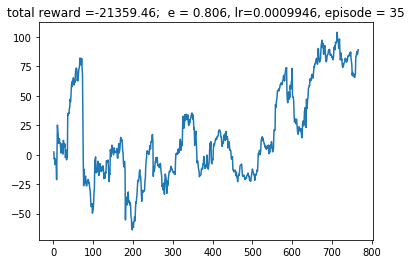

Waiting to train the whole dataset
action0:  915 
action1:  515 
action2:  520
DONE, lets roll!!
127.39


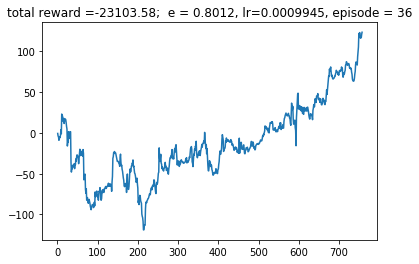

Waiting to train the whole dataset
action0:  911 
action1:  473 
action2:  566
DONE, lets roll!!
126.77


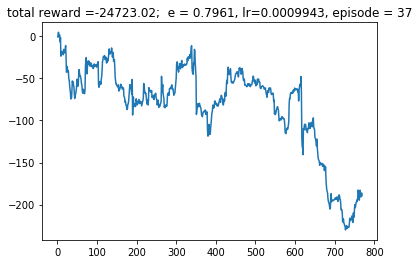

Waiting to train the whole dataset
action0:  912 
action1:  529 
action2:  509
DONE, lets roll!!
127.382


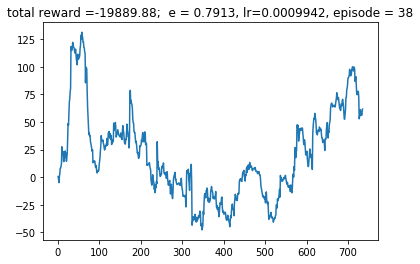

Waiting to train the whole dataset
action0:  954 
action1:  510 
action2:  486
DONE, lets roll!!
127.156


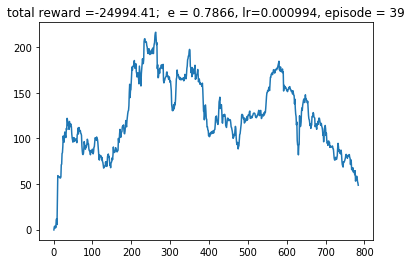

Waiting to train the whole dataset
action0:  918 
action1:  530 
action2:  502
DONE, lets roll!!
126.624


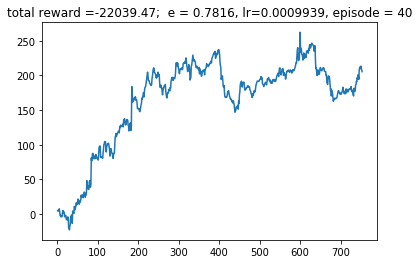

Waiting to train the whole dataset
action0:  929 
action1:  521 
action2:  500
DONE, lets roll!!
126.139


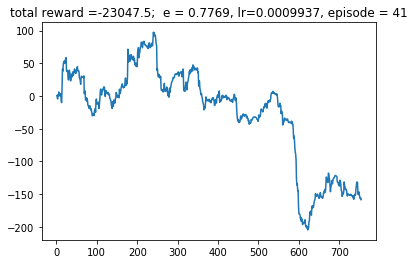

Waiting to train the whole dataset
action0:  901 
action1:  517 
action2:  532
DONE, lets roll!!
194.017


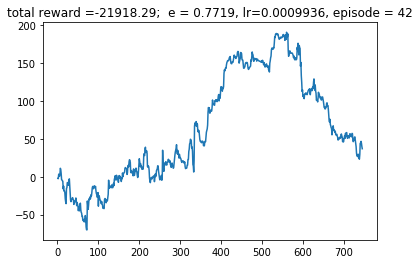

Waiting to train the whole dataset
action0:  944 
action1:  504 
action2:  502
DONE, lets roll!!
127.572


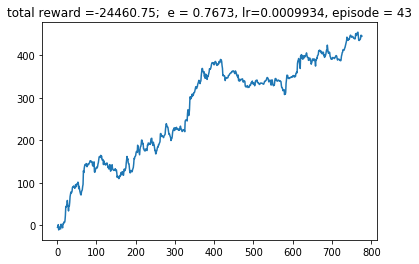

Waiting to train the whole dataset
action0:  873 
action1:  537 
action2:  540
DONE, lets roll!!
127.021


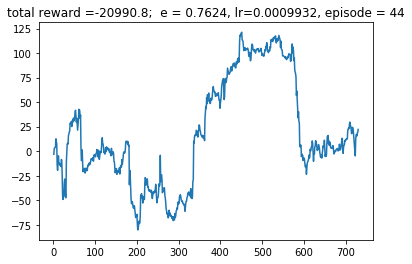

Waiting to train the whole dataset
action0:  958 
action1:  501 
action2:  491
DONE, lets roll!!
128.265


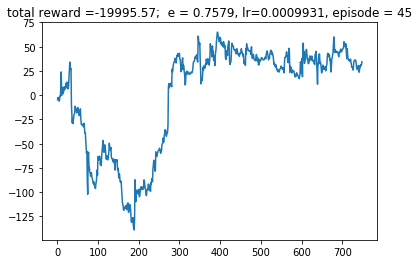

Waiting to train the whole dataset
action0:  968 
action1:  505 
action2:  477
DONE, lets roll!!
128.058


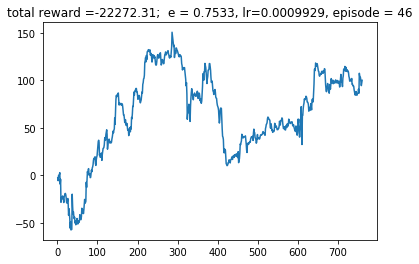

Waiting to train the whole dataset
action0:  961 
action1:  483 
action2:  506
DONE, lets roll!!
128.12


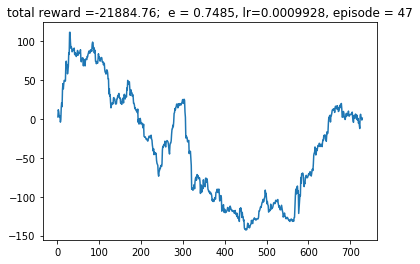

Waiting to train the whole dataset
action0:  971 
action1:  494 
action2:  485
DONE, lets roll!!
127.245


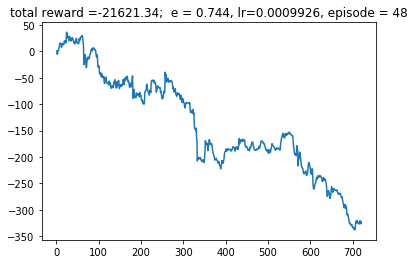

Waiting to train the whole dataset
action0:  1016 
action1:  491 
action2:  443
DONE, lets roll!!
127.899


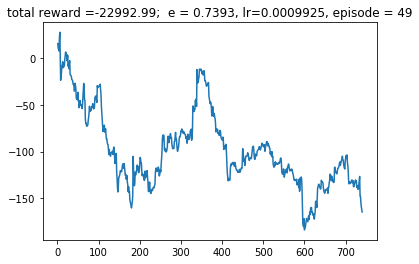

Waiting to train the whole dataset
action0:  957 
action1:  480 
action2:  513
DONE, lets roll!!
127.918


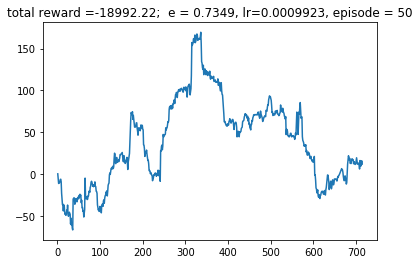

Waiting to train the whole dataset
action0:  1018 
action1:  457 
action2:  475
DONE, lets roll!!
127.722


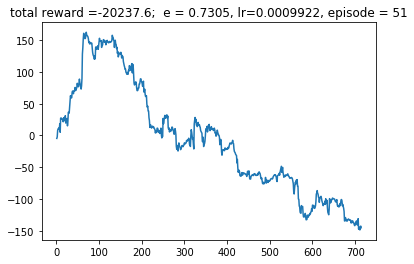

Waiting to train the whole dataset
action0:  1008 
action1:  456 
action2:  486
DONE, lets roll!!
127.591


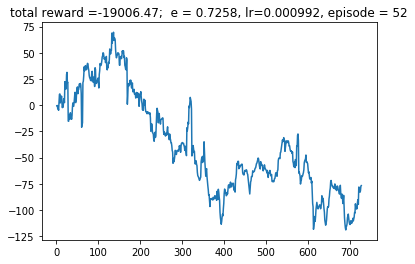

Waiting to train the whole dataset
action0:  1006 
action1:  475 
action2:  469
DONE, lets roll!!
127.946


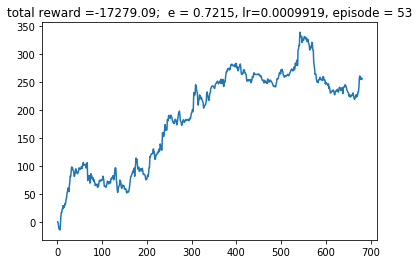

Waiting to train the whole dataset
action0:  1040 
action1:  432 
action2:  478
DONE, lets roll!!
129.175


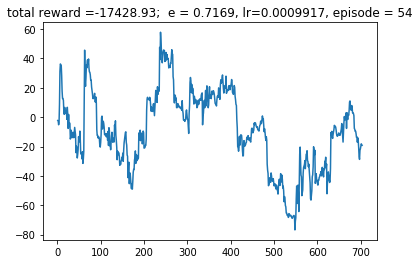

Waiting to train the whole dataset
action0:  1020 
action1:  451 
action2:  479
DONE, lets roll!!
128.591


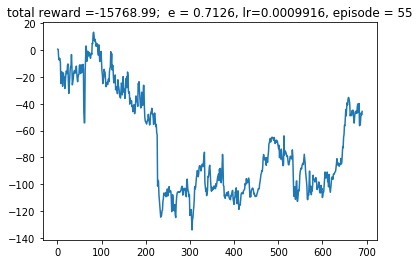

Waiting to train the whole dataset
action0:  1057 
action1:  419 
action2:  474
DONE, lets roll!!
128.107


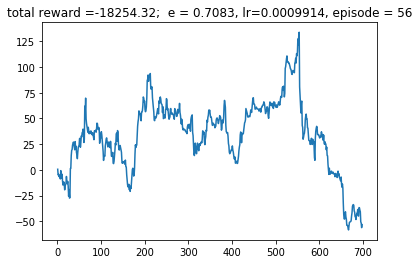

Waiting to train the whole dataset
action0:  1031 
action1:  456 
action2:  463
DONE, lets roll!!
129.377


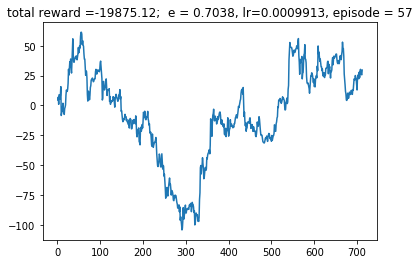

Waiting to train the whole dataset
action0:  1025 
action1:  470 
action2:  455
DONE, lets roll!!
128.877


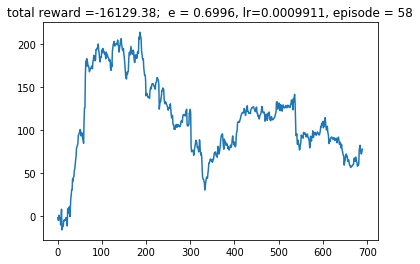

Waiting to train the whole dataset
action0:  1048 
action1:  445 
action2:  457
DONE, lets roll!!
128.206


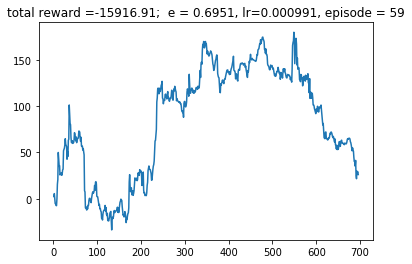

Waiting to train the whole dataset
action0:  1053 
action1:  438 
action2:  459
DONE, lets roll!!
128.863


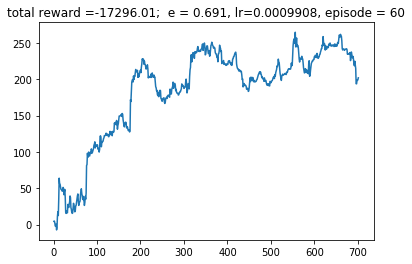

Waiting to train the whole dataset
action0:  1042 
action1:  467 
action2:  441
DONE, lets roll!!
128.296


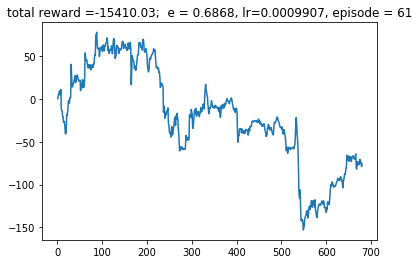

Waiting to train the whole dataset
action0:  1068 
action1:  438 
action2:  444
DONE, lets roll!!
128.575


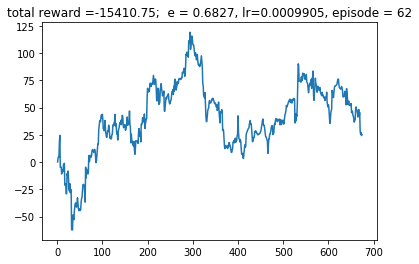

Waiting to train the whole dataset
action0:  1086 
action1:  449 
action2:  415
DONE, lets roll!!
128.504


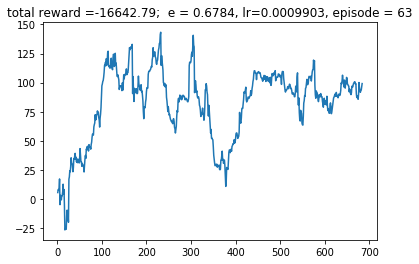

Waiting to train the whole dataset
action0:  1079 
action1:  438 
action2:  433
DONE, lets roll!!
128.875


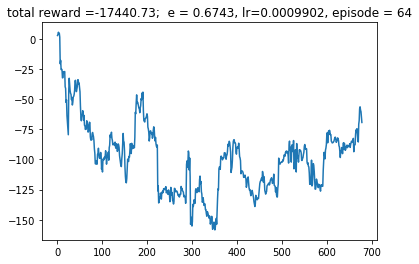

Waiting to train the whole dataset
action0:  1063 
action1:  434 
action2:  453
DONE, lets roll!!
128.382


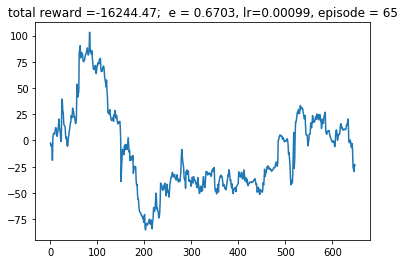

Waiting to train the whole dataset
action0:  1090 
action1:  435 
action2:  425
DONE, lets roll!!
128.354


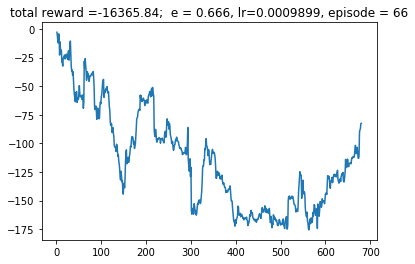

Waiting to train the whole dataset
action0:  1082 
action1:  409 
action2:  459
DONE, lets roll!!
128.902


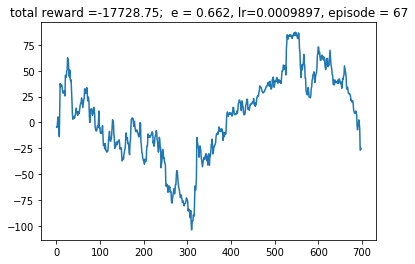

Waiting to train the whole dataset
action0:  1078 
action1:  449 
action2:  423
DONE, lets roll!!
128.681


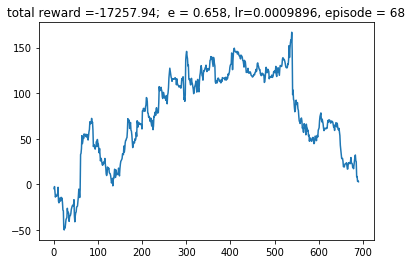

Waiting to train the whole dataset
action0:  1059 
action1:  444 
action2:  447
DONE, lets roll!!
128.857


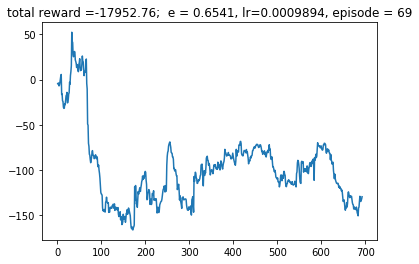

Waiting to train the whole dataset
action0:  1044 
action1:  483 
action2:  423
DONE, lets roll!!
129.028


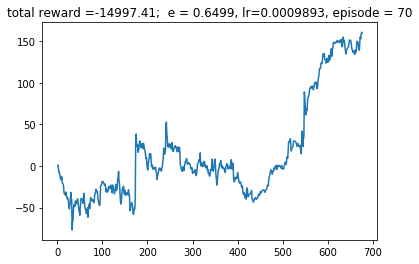

Waiting to train the whole dataset
action0:  1100 
action1:  420 
action2:  430
DONE, lets roll!!
130.753


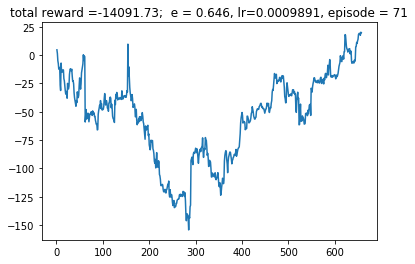

Waiting to train the whole dataset
action0:  1124 
action1:  417 
action2:  409
DONE, lets roll!!
130.114


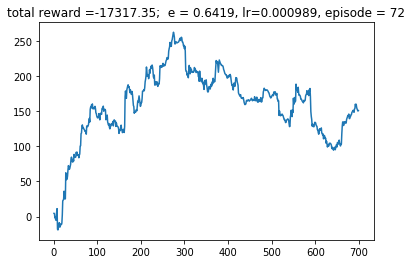

Waiting to train the whole dataset
action0:  1101 
action1:  434 
action2:  415
DONE, lets roll!!
129.422


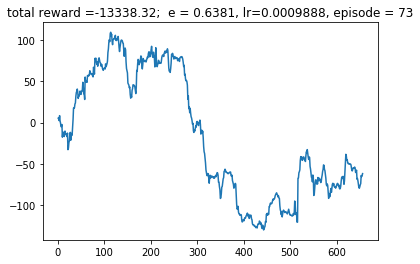

Waiting to train the whole dataset
action0:  1118 
action1:  413 
action2:  419
DONE, lets roll!!
129.249


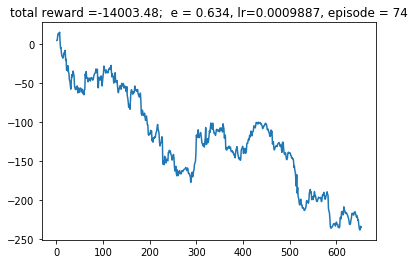

Waiting to train the whole dataset
action0:  1134 
action1:  430 
action2:  386
DONE, lets roll!!
130.162


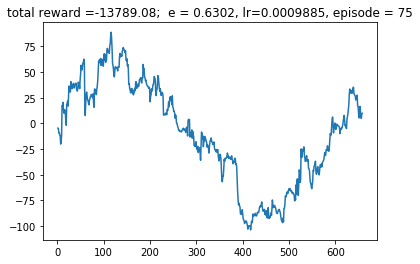

Waiting to train the whole dataset
action0:  1111 
action1:  411 
action2:  428
DONE, lets roll!!
144.183


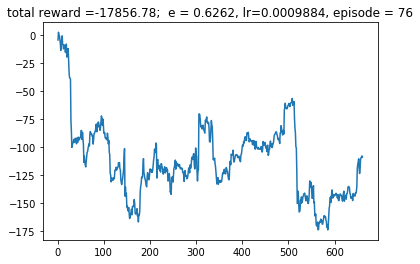

Waiting to train the whole dataset
action0:  981 
action1:  578 
action2:  391
DONE, lets roll!!
130.719


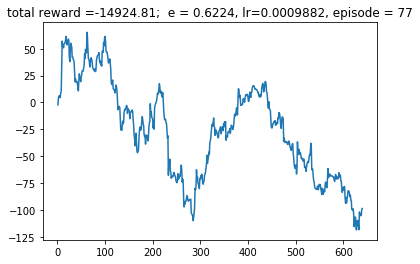

Waiting to train the whole dataset
action0:  1142 
action1:  432 
action2:  376
DONE, lets roll!!
130.266


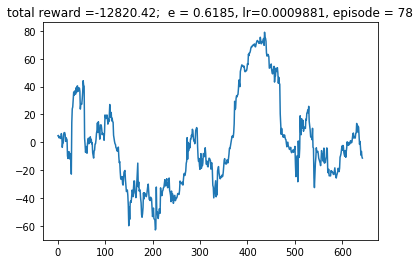

Waiting to train the whole dataset
action0:  1141 
action1:  406 
action2:  403
DONE, lets roll!!
129.982


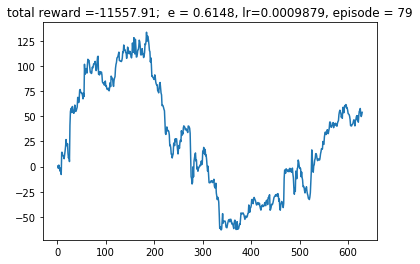

Waiting to train the whole dataset
action0:  1154 
action1:  364 
action2:  432
DONE, lets roll!!
130.313


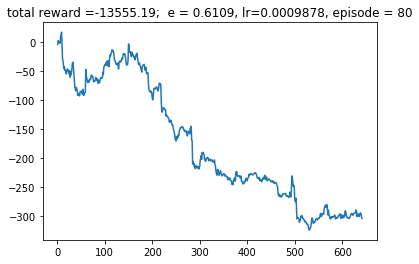

Waiting to train the whole dataset
action0:  1134 
action1:  397 
action2:  419
DONE, lets roll!!
131.231


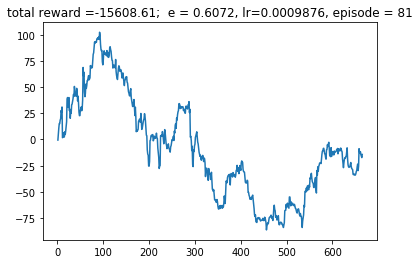

Waiting to train the whole dataset
action0:  1143 
action1:  386 
action2:  421
DONE, lets roll!!
129.618


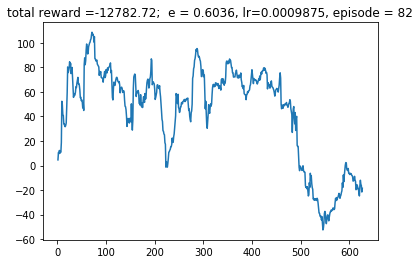

Waiting to train the whole dataset
action0:  1168 
action1:  373 
action2:  409
DONE, lets roll!!
130.093


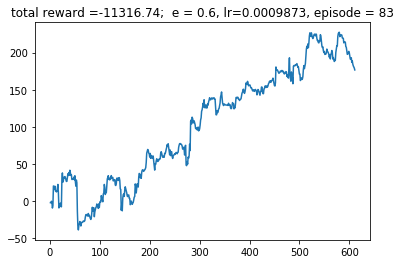

Waiting to train the whole dataset
action0:  1187 
action1:  363 
action2:  400
DONE, lets roll!!
130.04


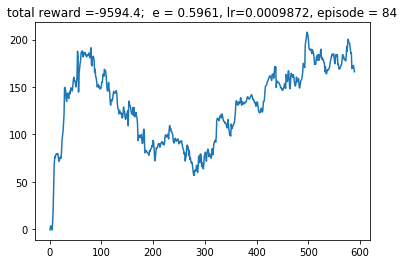

Waiting to train the whole dataset
action0:  1217 
action1:  342 
action2:  391
DONE, lets roll!!
129.791


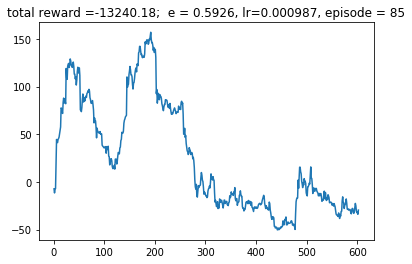

Waiting to train the whole dataset
action0:  1169 
action1:  378 
action2:  403
DONE, lets roll!!
130.262


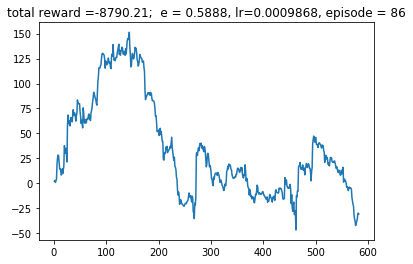

Waiting to train the whole dataset
action0:  1217 
action1:  336 
action2:  397
DONE, lets roll!!
129.985


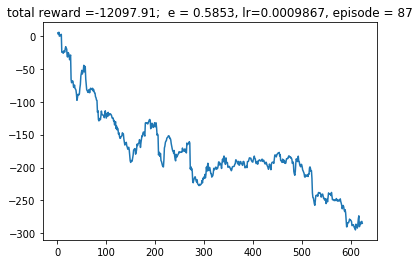

Waiting to train the whole dataset
action0:  1195 
action1:  389 
action2:  366
DONE, lets roll!!
129.899


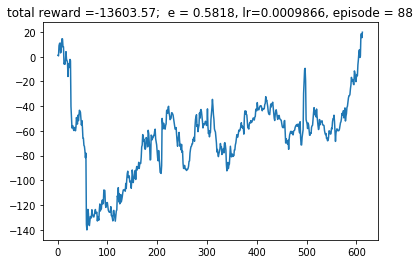

Waiting to train the whole dataset
action0:  1177 
action1:  397 
action2:  376
DONE, lets roll!!
130.235


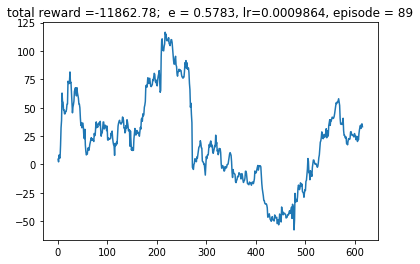

Waiting to train the whole dataset
action0:  1167 
action1:  384 
action2:  399
DONE, lets roll!!
131.209


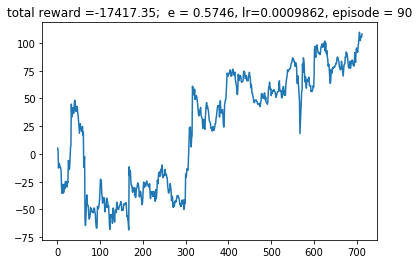

Waiting to train the whole dataset
action0:  955 
action1:  649 
action2:  346
DONE, lets roll!!
131.598


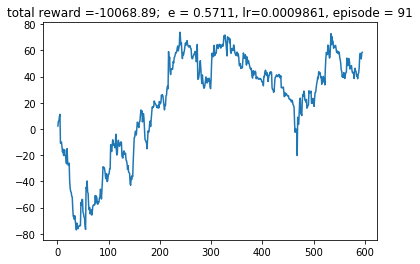

Waiting to train the whole dataset
action0:  1209 
action1:  372 
action2:  369
DONE, lets roll!!
130.873


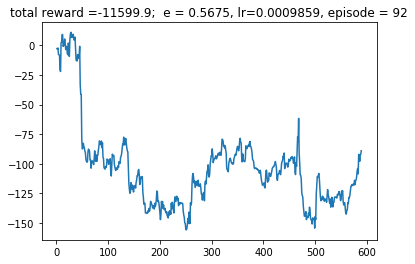

Waiting to train the whole dataset
action0:  1205 
action1:  380 
action2:  365
DONE, lets roll!!
131.587


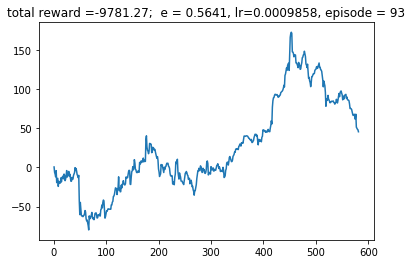

Waiting to train the whole dataset
action0:  1226 
action1:  350 
action2:  374
DONE, lets roll!!
131.442


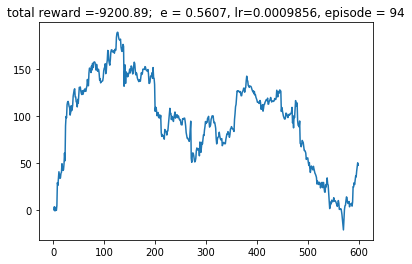

Waiting to train the whole dataset
action0:  1206 
action1:  356 
action2:  388
DONE, lets roll!!
130.856


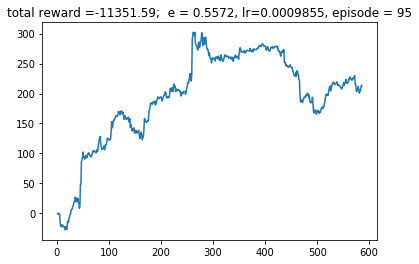

Waiting to train the whole dataset
action0:  1153 
action1:  474 
action2:  323
DONE, lets roll!!
131.636


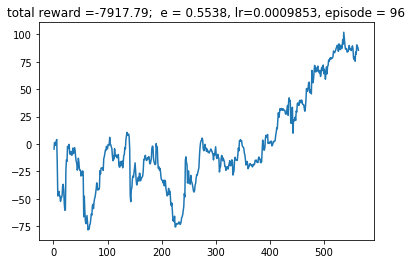

Waiting to train the whole dataset
action0:  1257 
action1:  357 
action2:  336
DONE, lets roll!!
131.498


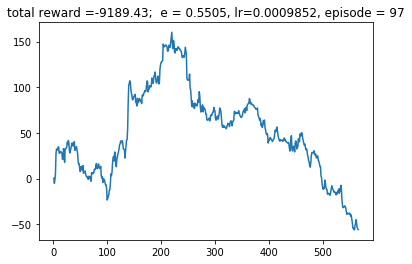

Waiting to train the whole dataset
action0:  1242 
action1:  368 
action2:  340
DONE, lets roll!!
131.538


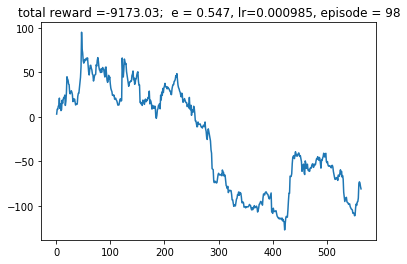

Waiting to train the whole dataset
action0:  1250 
action1:  337 
action2:  363
DONE, lets roll!!
134.987


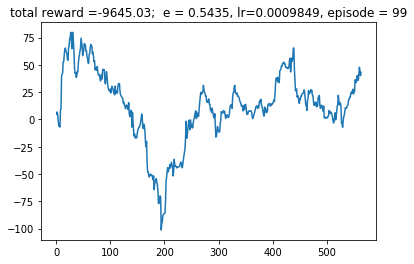

Waiting to train the whole dataset
action0:  1265 
action1:  344 
action2:  341
DONE, lets roll!!
134.035


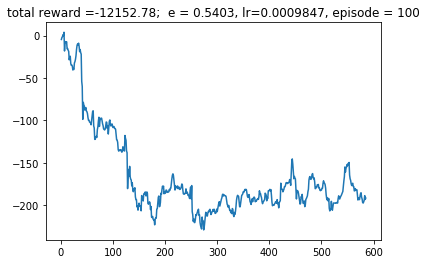

Waiting to train the whole dataset
action0:  1155 
action1:  422 
action2:  373
DONE, lets roll!!
131.404


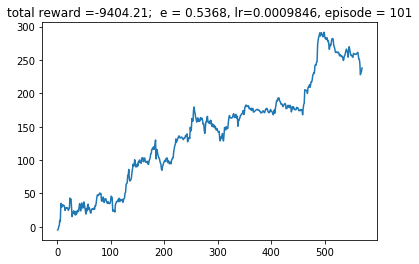

Waiting to train the whole dataset
action0:  1241 
action1:  327 
action2:  382
DONE, lets roll!!
131.288


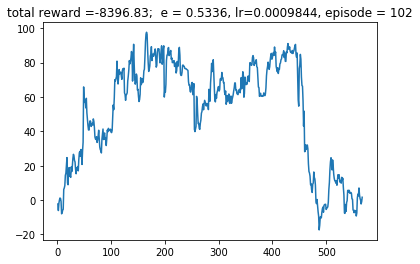

Waiting to train the whole dataset
action0:  1268 
action1:  349 
action2:  333
DONE, lets roll!!
131.901


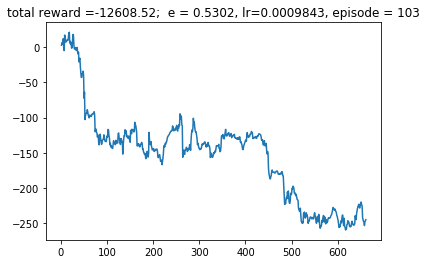

Waiting to train the whole dataset
action0:  1123 
action1:  495 
action2:  332
DONE, lets roll!!
132.365


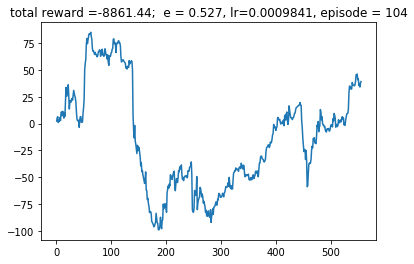

Waiting to train the whole dataset
action0:  1273 
action1:  349 
action2:  328
DONE, lets roll!!
131.466


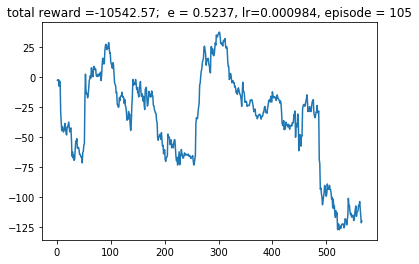

Waiting to train the whole dataset
action0:  1199 
action1:  407 
action2:  344
DONE, lets roll!!
132.245


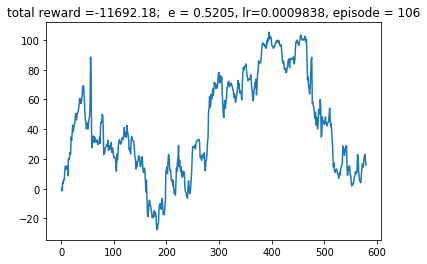

Waiting to train the whole dataset
action0:  1240 
action1:  391 
action2:  319
DONE, lets roll!!
131.748


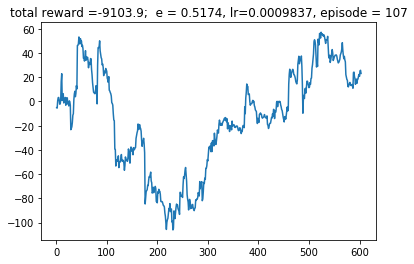

Waiting to train the whole dataset
action0:  1201 
action1:  382 
action2:  367
DONE, lets roll!!
131.185


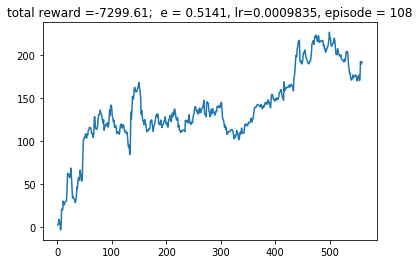

Waiting to train the whole dataset
action0:  1268 
action1:  351 
action2:  331
DONE, lets roll!!
132.713


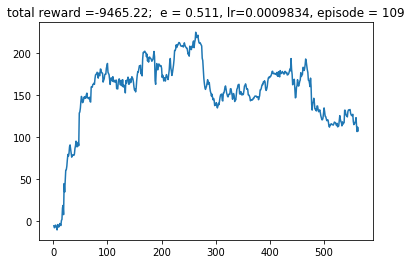

Waiting to train the whole dataset
action0:  1268 
action1:  344 
action2:  338
DONE, lets roll!!
132.318


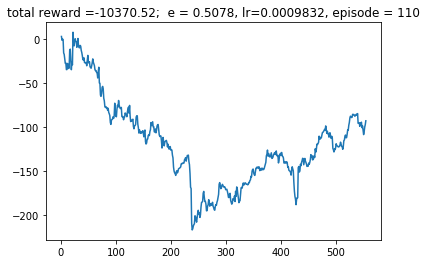

Waiting to train the whole dataset
action0:  1252 
action1:  368 
action2:  330
DONE, lets roll!!
133.089


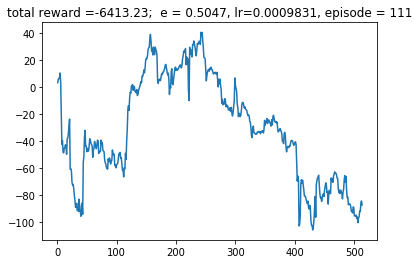

Waiting to train the whole dataset
action0:  1327 
action1:  320 
action2:  303
DONE, lets roll!!
132.218


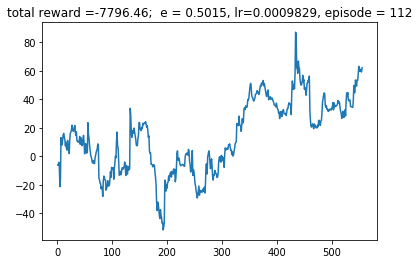

Waiting to train the whole dataset
action0:  1287 
action1:  319 
action2:  344
DONE, lets roll!!
134.323


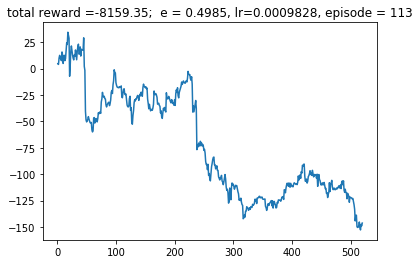

Waiting to train the whole dataset
action0:  1326 
action1:  318 
action2:  306
DONE, lets roll!!
133.965


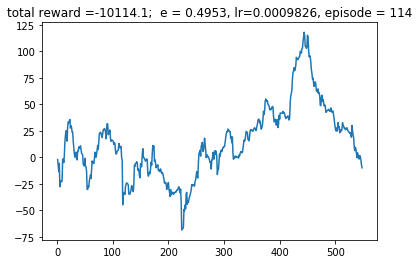

Waiting to train the whole dataset
action0:  1284 
action1:  309 
action2:  357
DONE, lets roll!!
132.13


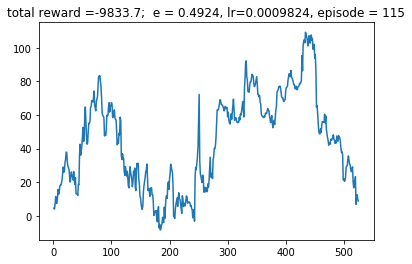

Waiting to train the whole dataset
action0:  1313 
action1:  326 
action2:  311


In [ ]:
env = Trevor(Dataframe())
state_size = (NUMBER_OF_SAMPLES, 9)
action_size = 3
batch_size = 32
agent = DQNAgent(state_size, action_size, batch_size)

#agent.save("./save/cartpole-ddqn.h5")
agent.load("./save/cartpole-ddqn.h5")

closed = False
run = False

for e in range(EPISODES):
    state = env.reset()
    strt = t_lib.time()
    
    akce0 = 0
    akce1 = 0
    akce2 = 0
    
    for time in range(env.df.lenght):
        action, random_action = agent.act(state)

        if action > 3 or action < 0:
            print('Got action ' + action)
            continue

        next_state, reward, closed, _ = env.step(action)

        if not isinstance(next_state, np.ndarray) or not(state, np.ndarray):
            print(next_state)
            print('NOT NUMPY!!')
            continue

        agent.memorize(state=state, action=action, reward=reward, next_state=next_state, done=closed)
        state = next_state
        
        """
        print(f'Actual reward = {round(reward, 1)},\t total reward = {round(env.total_reward, 1)},'
              f'\t action = {action}, \t trade_counter = {round(env.trade_counter, 1)}, '
              f'\t pip_counter = {round(env.closed_counter, 1)}'
              f'\t random_action = {random_action}'
              f'\t candle_number = {time}')
        """
        if action == 0:
            akce0 += 1
        if action == 1:
            akce1 += 1
        if action == 2:
            akce2 += 1
        
        # print("Actual reward = {}\t, total reward = {},\t action = {}\t trade_counter = {}\t pip_counter = {}".format(round(reward, 1), round(env.total_reward, 1), action, round(env.trade_counter, 1), round(env.closed_counter, 1)))
        if closed and reward > 80 * TIMES_FACTOR:
            agent.update_target_model()
            """
            print("episode: {}/{}, score: {}, e: {}, lr: {}"
                  .format(e, EPISODES, time, round(agent.epsilon, 2)), round(agent.learning_rate, 2))
            """
            print('More than 80 on candle {}'.format(time))
        
        if len(agent.memory) > batch_size:
            # agent.replay(batch_size)
            if not run:
                thr_list = [Thread(target=agent.replay) for _ in range(1)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                    
                thr_list = [Thread(target=agent.train_from_iterations) for _ in range(4)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                
                run = True
                
    # clear_output()
    env.plot(title='total reward ={};  e = {}, lr={}, episode = {}'.format(round(env.total_reward, 2), round(agent.epsilon, 4), round(agent.learning_rate, 7), e))
    env.reset_closed_list()
    print('Waiting to train the whole dataset')
    print("action0: ", akce0,"\naction1: ", akce1,"\naction2: ", akce2)
    while not len(agent.sample_memory) == 0:
        pass
    agent.set_learning_rate()
    print('DONE, lets roll!!')
    agent.save("./save/cartpole-ddqn.h5")
    print(round(t_lib.time() - strt, 3))